<a href="https://colab.research.google.com/github/BrunoAFurquim/Sugarcane-Disease-Classification/blob/main/sugarcane_disease_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python matplotlib numpy

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from google.colab import files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Viral Disease.zip to Viral Disease.zip


In [ ]:
from collections import defaultdict

# 1. Dicionário para mapear classes
class_zips = {
    'dried': 'Dried Leaves.zip',
    'healthy': 'Healthy Leaves.zip',
    'sett_rot': 'Sett Rot.zip',
    'viral_disease': 'Viral Disease.zip'
}

# 2. Extração e análise
class_stats = defaultdict(lambda: {
    'heights': [],
    'widths': [],
    'means': [],
    'stds': [],
    'image_paths': []
})

Extraindo Zips e Coletando Estatísticas

In [ ]:
for class_name, zip_file in class_zips.items():
    if not os.path.exists(zip_file):
        print(f"AVISO: Arquivo {zip_file} não encontrado. Pulando...")
        continue

    extract_path = f'/content/{class_name}'
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    for root, _, files in os.walk(extract_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)

                if img is not None:
                    h, w, c = img.shape if len(img.shape) == 3 else (*img.shape[:2], 1)
                    class_stats[class_name]['channels'] = c

                    if c == 1:
                        mean, std = cv2.meanStdDev(img)
                    else:
                        mean, std = cv2.meanStdDev(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

                    class_stats[class_name]['heights'].append(h)
                    class_stats[class_name]['widths'].append(w)
                    class_stats[class_name]['means'].append(mean)
                    class_stats[class_name]['stds'].append(std)
                    class_stats[class_name]['image_paths'].append(img_path)


Função para mostrar estatísticas por classe

In [ ]:
def print_class_stats(stats, class_name):
    data = stats[class_name]
    print(f"\n{'='*50}")
    print(f"Análise da classe: {class_name.upper()}")
    print(f"{'='*50}")
    print(f"Total de imagens: {len(data['heights'])/4}")
    print(f"Altura média: {np.mean(data['heights']):.2f} ± {np.std(data['heights']):.2f} px")
    print(f"Largura média: {np.mean(data['widths']):.2f} ± {np.std(data['widths']):.2f} px")
    print(f"Número de canais: {data['channels']}")

    if data['means']:
        mean_channels = np.mean(np.concatenate(data['means'], axis=1), axis=0)
        std_channels = np.mean(np.concatenate(data['stds'], axis=1), axis=0)

        print("\nMédia de cores:")
        if len(mean_channels) == 1:
            print(f"Gray: {mean_channels[0]:.2f} ± {std_channels[0]:.2f}")
        else:
            for i, color in enumerate(['Red', 'Green', 'Blue']):
                print(f"{color}: {mean_channels[i]:.2f} ± {std_channels[i]:.2f}")

for class_name in class_zips.keys():
    if class_name in class_stats:
        print_class_stats(class_stats, class_name)



Análise da classe: DRIED
Total de imagens: 343.0
Altura média: 1024.00 ± 0.00 px
Largura média: 768.00 ± 0.00 px
Número de canais: 3

Média de cores:
Red: 170.24 ± 22.49
Green: 169.33 ± 22.39
Blue: 174.27 ± 24.13

Análise da classe: HEALTHY
Total de imagens: 430.0
Altura média: 1008.37 ± 82.20 px
Largura média: 768.00 ± 0.00 px
Número de canais: 3

Média de cores:
Red: 101.99 ± 45.35
Green: 97.37 ± 48.87
Blue: 159.97 ± 36.37

Análise da classe: SETT_ROT
Total de imagens: 652.0
Altura média: 1024.00 ± 0.00 px
Largura média: 768.00 ± 0.00 px
Número de canais: 3

Média de cores:
Red: 126.39 ± 49.75
Green: 133.11 ± 47.36
Blue: 117.69 ± 50.62

Análise da classe: VIRAL_DISEASE
Total de imagens: 663.0
Altura média: 950.35 ± 166.05 px
Largura média: 768.00 ± 0.00 px
Número de canais: 3

Média de cores:
Red: 156.00 ± 37.41
Green: 171.78 ± 32.26
Blue: 156.54 ± 39.56


Bloxplot de dimensões

<ipython-input-35-3fd5c04bd614>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_heights, labels=list(class_stats.keys()))


(array([1, 2, 3, 4]),
 [Text(1, 0, 'dried'),
  Text(2, 0, 'healthy'),
  Text(3, 0, 'sett_rot'),
  Text(4, 0, 'viral_disease')])

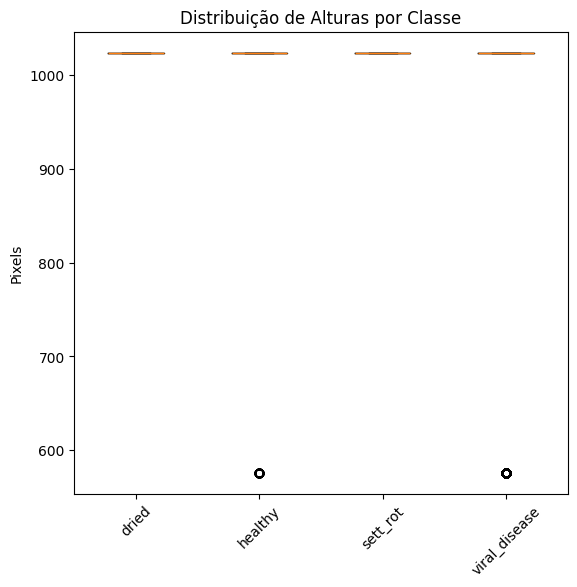

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
all_heights = [class_stats[cls]['heights'] for cls in class_stats]
plt.boxplot(all_heights, labels=list(class_stats.keys()))
plt.title('Distribuição de Alturas por Classe')
plt.ylabel('Pixels')
plt.xticks(rotation=45)

Bloxplot de intensidades

<ipython-input-34-7f37391ae3cc>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(intensities, labels=labels)


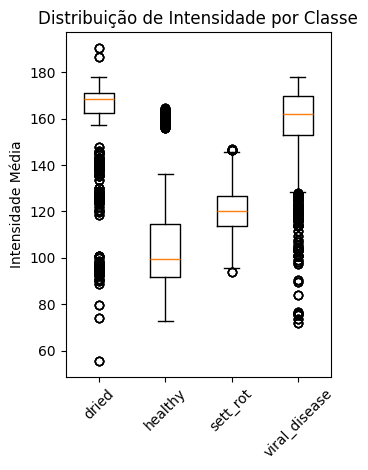

In [ ]:
plt.subplot(1, 2, 2)
intensities = []
labels = []
for cls in class_stats:
    if class_stats[cls]['channels'] == 1:
        intensities.append(np.concatenate(class_stats[cls]['means']).flatten())
        labels.append(cls)
    else:
        # Pega apenas o canal Red (índice 0) pois convertemos para RGB
        intensities.append(np.concatenate(class_stats[cls]['means'])[:, 0])
        labels.append(cls)

plt.boxplot(intensities, labels=labels)
plt.title('Distribuição de Intensidade por Classe')
plt.ylabel('Intensidade Média')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Vizualização de Exemplos

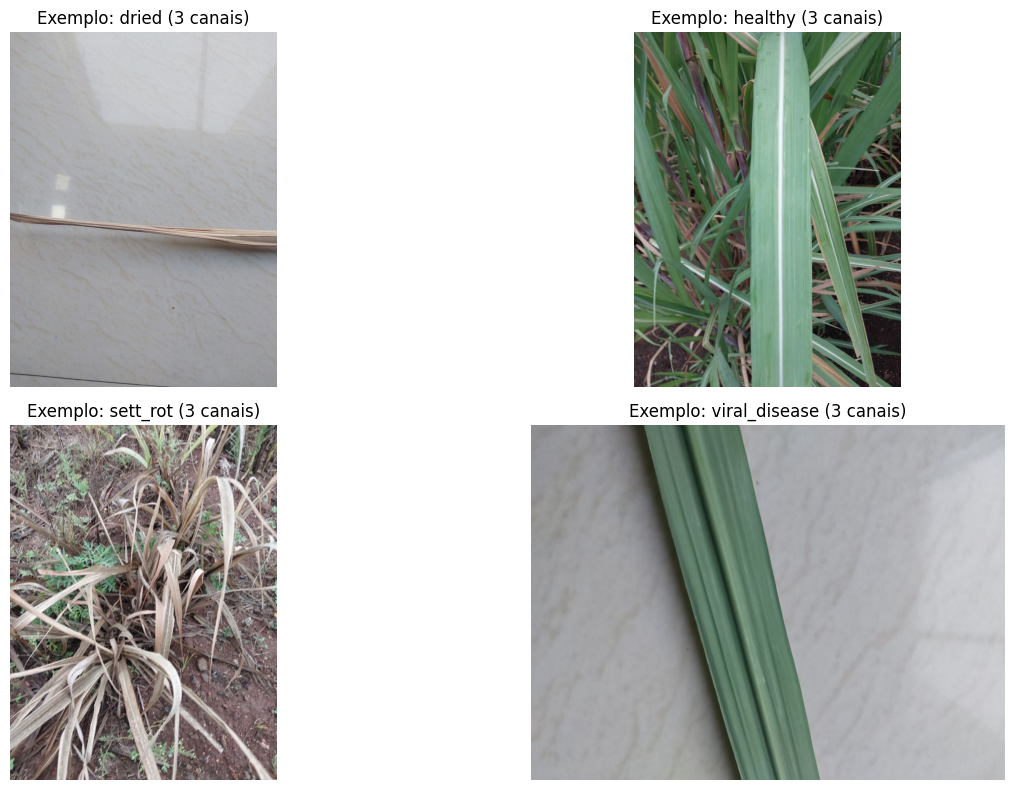

In [ ]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_stats, 1):
    img_path = class_stats[class_name]['image_paths'][0]
    img = cv2.imread(img_path)

    plt.subplot(2, 2, i)
    if class_stats[class_name]['channels'] == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertendo para RGB
    plt.title(f'Exemplo: {class_name} ({class_stats[class_name]["channels"]} canais)')
    plt.axis('off')

plt.tight_layout()
plt.show()